In [223]:
# Импорты

import warnings
import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
import pickle

pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')
random.seed(42)
np.random.seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [224]:
# Загрузка данных и предобработка

data = pd.read_excel('files/train.xlsx', header=5)

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.replace(' ', 0, inplace=True)
data.fillna(0, inplace=True)
data.fillna(0, inplace=True)
data.fillna(0, inplace=True)

for col in data.columns:
    data.rename(columns={col: col.replace('(', ' ').replace(')', ' ').replace('\n', ' ').replace('.', ' ')}, inplace=True)

data['Начало нед'] = pd.to_datetime(data['Начало нед'])
data = data[data['Начало нед']<pd.to_datetime('2023-09-04')]
data.set_index('Начало нед', inplace=True)

data.drop(columns=['год', 'неделя', 'Unnamed: 147'], inplace=True)
# data[['Продажи, рубли', 'Продажи, упаковки']] = 0, 0

split_size = int(data.shape[0] / 4)
train_split, val_split = split_size*2, split_size*3
train = data[0:train_split]
val = data[train_split:val_split]
test = data[val_split:]

In [225]:
data

,"Продажи, рубли","Продажи, упаковки","Продажи, рубли 1","раствор 0 01 % 150 мл N1, руб","раствор 0 01 % 50 мл N1, руб","раствор 0 01 % 500 мл N1, руб","раствор 0 01 % 150 мл N1, упаковки","раствор 0 01 % 50 мл N1, упаковки","раствор 0 01 % 500 мл N1, упаковки",Дистрибуция Мирамистин,Выписки,Статистика заболеваемости,Индекс цены,Развитие Дженериков средняя дистрибуция,Развитие Дженериков кол-во брендов,"1 ТВ, trp Ж 30-60 ВС","1 ТВ, рубли","1 ТВ, охват 5+ Ж 30-60 ВС","2 ТВ, trp Ж 30-60 ВС","2 ТВ, рубли","2 ТВ, охват 5+ Ж 30-60 ВС","3 ТВ, trp Ж 30-60 ВС","3 ТВ, рубли","3 ТВ, охват 5+ Ж 30-60 ВС","4 ТВ, trp Ж 30-60 ВС","4 ТВ, рубли","4 ТВ, охват 5+ Ж 30-60 ВС","тотал ТВ, trp Ж 30-60 ВС","тотал ТВ, рубли","тотал ТВ, охват 5+ Ж 30-60 ВС","Диджитал, рубли","Радио, рубли","Радио, количество выходов",Запросы Wordstat,"ТВ, trp Ж 30-60 ВС","ТВ, охват 5+ Ж 30-60 ВС","ТВ, рубли","Диджитал, руб","ТВ спонсорство, рубли","OOH, рубли","Радио, рубли 1",Итого,"ТВ, trp Ж 30-60 ВС 1","ТВ, охват 5+ Ж 30-60 ВС 1","ТВ, рубли 1","Диджитал, руб 1","ТВ спонсорство, рубли 1","OOH, рубли 1","Радио, рубли 2",Итого 1,"ТВ, trp Ж 30-60 ВС 2","ТВ, охват 5+ Ж 30-60 ВС 2","ТВ, рубли 2","Диджитал, руб 2","ТВ спонсорство, рубли 2","OOH, рубли 2","Радио, рубли 3","ТВ Рег, рубли",Итого 2,"ТВ, trp Ж 30-60 ВС 3","ТВ, охват 5+ Ж 30-60 ВС 3","ТВ, рубли 3","Диджитал, руб 3","ТВ спонсорство, рубли 3","OOH, рубли 3","Радио, рубли 4",Итого 3,"ТВ, trp Ж 30-60 ВС 4","ТВ, охват 5+ Ж 30-60 ВС 4","ТВ, рубли 4","Диджитал, руб 4","ТВ спонсорство, рубли 4","OOH, рубли 4","Радио, рубли 5","ТВ Рег, рубли 1",Итого 4,"ТВ, trp Ж 30-60 ВС 5","ТВ, охват 5+ Ж 30-60 ВС 5","ТВ, рубли 5","Диджитал, руб 5","ТВ спонсорство, рубли 5","OOH, рубли 5","Радио, рубли 6","ТВ Рег, рубли 2",Итого 5,"ТВ, trp Ж 30-60 ВС 6","ТВ, охват 5+ Ж 30-60 ВС 6","ТВ, рубли 6","Диджитал, руб 6","ТВ спонсорство, рубли 6","OOH, рубли 6","Радио, рубли 7","ТВ Рег, рубли 3",Итого 6,"ТВ, trp Ж 30-60 ВС 7","ТВ, охват 5+ Ж 30-60 ВС 7","ТВ, рубли 7","Диджитал, руб 7","ТВ спонсорство, рубли 7","OOH, рубли 7","Радио, рубли 8",Итого 7,"ТВ, trp Ж 30-60 ВС 8","ТВ, охват 5+ Ж 30-60 ВС 8","ТВ, рубли 8","Диджитал, руб 8","ТВ спонсорство, рубли 8","OOH, рубли 8","Радио, рубли 9","ТВ Рег, рубли 4",Итого 8,"ТВ, trp Ж 30-60 ВС 9","ТВ, охват 5+ Ж 30-60 ВС 9","ТВ, рубли 9","Диджитал, руб 9","ТВ спонсорство, рубли 9","OOH, рубли 9","Радио, рубли 10",Итого 9,"ТВ, trp Ж 30-60 ВС 10","ТВ, охват 5+ Ж 30-60 ВС 10","ТВ, рубли 10","Диджитал, руб 10","ТВ спонсорство, рубли 10","OOH, рубли 10","Радио, рубли 11",Итого 10,"ТВ, trp Ж 30-60 ВС 11","ТВ, охват 5+ Ж 30-60 ВС 11","ТВ, рубли 11","Диджитал, руб 11","ТВ спонсорство, рубли 11","OOH, рубли 11","Радио, рубли 12","ТВ Рег, рубли 5",Итого 11,"ТВ, trp Ж 30-60 ВС 12","ТВ, охват 5+ Ж 30-60 ВС 12","ТВ, рубли 12","Диджитал, руб 12","ТВ спонсорство, рубли 12","OOH, рубли 12","Радио, рубли 13",Итого 12
Начало нед,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-31,4.153557e+07,114621.15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,508956.0,1.541320,0.000000,0.00,0.000000,0.000000e+00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0000,1057612.50,0.000000e+00,0.0,76854.75,0.000000,0.0000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.606934e+06,1.606934e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.813979e+06,3.813979e+06,0.000000,0.000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.000,294.149196,23.6985,5.174524e+06,0.0,0.0,0.0,0.0,0.0,5.174524e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293.114917,21.9240,5.670257e+06,227587.5,0.0,0.0,0.0,5.897845e+06,191.587053,9.8385,1.645239e+06,3.033352e+06,0.0,0.0,0.0,7.155664e+06,1.183425e+07,207.903106,15.3615,9.085528e+06,0.0,0.0,0.0,0.0,9.085528e+06
2019-01-0

In [226]:
# Подготовка датасетов

y_train_true = train[['Продажи, рубли']]
y_val_true = val[['Продажи, рубли']]
y_test_true = test[['Продажи, рубли']]

# train['Продажи, рубли'] = 0
# val['Продажи, рубли'] = 0
# test['Продажи, рубли'] = 0

# train['Продажи, упаковки'] = 0
# val['Продажи, упаковки'] = 0
# test['Продажи, упаковки'] = 0

scaler = StandardScaler()
# features = data.drop(columns=['Продажи, рубли', 'Продажи, упаковки']).columns.to_list()[0:12] + ['Запросы Wordstat']
features = data.drop(columns=['Продажи, рубли', 'Продажи, упаковки']).columns.to_list()
features += ['Продажи, рубли', 'Продажи, упаковки']
scaler.fit(data[features])
print(features)

X_train = scaler.transform(train[features])
X_val = scaler.transform(val[features])
X_test = scaler.transform(test[features])
y_train = y_train_true.copy()
y_val = y_val_true.copy()
y_test = y_test_true.copy()

target_scaler = MinMaxScaler(feature_range=(0, 1))
y_train['Продажи, рубли'] = target_scaler.fit_transform(y_train)
y_val['Продажи, рубли'] = target_scaler.transform(y_val)
y_test['Продажи, рубли'] = target_scaler.transform(y_test)

n_past = 4 # Сколько недель прошлого берем
n_future = 29 # Горизонт предикта
n_features = len(features)

# Нарезаем пары по n_past недель прошлого с фичами и по n_future недель с таргетом
def create_sequences(input_data, target_data, n_past, n_future):
    X, y = [], []
    for i in range(n_past, len(input_data) - n_future +1):
        X.append(input_data[i - n_past:i])
        y.append(target_data[i:i + n_future])
    return np.array(X), np.array(y)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_past, n_future)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, n_past, n_future)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_past, n_future)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq_tensor = torch.tensor(y_test_seq, dtype=torch.float32)
X_val_seq_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_seq_tensor = torch.tensor(y_val_seq, dtype=torch.float32)

batch_size = 16

train_dataset = TensorDataset(X_train_seq_tensor, y_train_seq_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_seq_tensor, y_val_seq_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_seq_tensor, y_test_seq_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dump(scaler, open('files/scaler.pkl', 'wb'))
dump(target_scaler, open('files/target_scaler.pkl', 'wb'))

['Продажи, рубли 1', 'раствор 0 01 % 150 мл N1, руб', 'раствор  0 01 % 50 мл N1, руб', 'раствор 0 01 % 500 мл N1, руб', 'раствор 0 01 % 150 мл N1, упаковки', 'раствор  0 01 % 50 мл N1, упаковки', 'раствор 0 01 % 500 мл N1, упаковки', 'Дистрибуция Мирамистин', 'Выписки ', 'Статистика заболеваемости', 'Индекс цены', 'Развитие Дженериков   средняя дистрибуция ', 'Развитие Дженериков   кол-во брендов ', ' 1  ТВ, trp  Ж 30-60 ВС ', ' 1  ТВ, рубли', ' 1  ТВ, охват 5+  Ж 30-60 ВС ', ' 2  ТВ, trp  Ж 30-60 ВС ', ' 2  ТВ, рубли', ' 2  ТВ, охват 5+  Ж 30-60 ВС ', ' 3  ТВ, trp  Ж 30-60 ВС ', ' 3  ТВ, рубли', ' 3  ТВ, охват 5+  Ж 30-60 ВС ', ' 4  ТВ, trp  Ж 30-60 ВС ', ' 4  ТВ, рубли', ' 4  ТВ, охват 5+  Ж 30-60 ВС ', ' тотал  ТВ, trp  Ж 30-60 ВС ', ' тотал  ТВ, рубли', ' тотал  ТВ, охват 5+  Ж 30-60 ВС ', 'Диджитал, рубли', 'Радио, рубли', 'Радио, количество выходов ', 'Запросы Wordstat', 'ТВ, trp  Ж 30-60 ВС ', 'ТВ, охват 5+  Ж 30-60 ВС ', 'ТВ, рубли', 'Диджитал, руб', 'ТВ спонсорство, рубли', 'O

In [227]:
# Объявление модели

class SalesForecast(nn.Module):
    def __init__(self, input_dim, output_dim, n_future, n_past):
        super(SalesForecast, self).__init__()
        self.layer1 = nn.Linear(input_dim*n_past, 100)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(100)
        self.layer2 = nn.Linear(100, 50)
        self.batchnorm2 = nn.BatchNorm1d(50)
        self.output_layer = nn.Linear(50, n_future)

    def forward(self, x):
        # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.relu(self.batchnorm1(self.layer1(x)))
        # print(x.size())
        x = self.relu(self.batchnorm2(self.layer2(x)))
        # print(x.size())
        x = self.output_layer(x)
        # print(x.size())
        return x

input_dim = len(features)
output_dim = n_future
model = SalesForecast(input_dim, output_dim, output_dim, n_past)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

Epoch 1/50, Training Loss: 0.3841402654846509, Validation Loss: 0.9902462363243103
new LR: 0.010000000000000002
Epoch 11/50, Training Loss: 0.021407374336073797, Validation Loss: 0.02064807154238224
new LR: 0.0010000000000000002
new LR: 0.00010000000000000003
new LR: 1.0000000000000004e-05
Training complete.


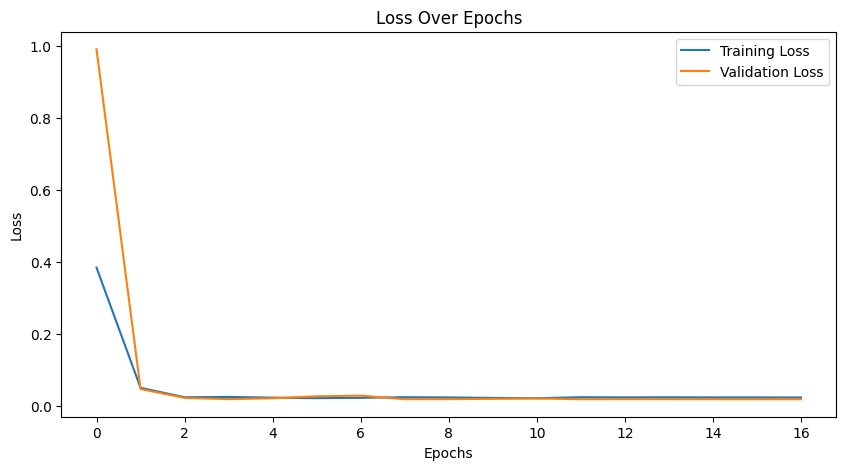

<All keys matched successfully>

In [228]:
# Обучение

num_epochs = 50
best_val_loss = float('inf')
train_losses, val_losses = [], []
scheduler_patience = 3
scheduler_break = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(targets.size(0), -1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, targets.view(targets.size(0), -1))
            total_val_loss += val_loss.item()
    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'files/best_model.pth')
        counter = 0
    else:
        counter += 1

    if counter >= scheduler_patience:
        model.load_state_dict(torch.load('files/best_model.pth'))
        # model = model.to(device)
        scheduler.step()
        print('new LR:', optimizer.param_groups[0]["lr"])
        counter = 0
        scheduler_break -= 1

    if scheduler_break < 0:
        break

print("Training complete.")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.load_state_dict(torch.load('files/best_model.pth'))
# model = model.to(device)

In [229]:
# Оценка на валидации

model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        predictions.extend(outputs.numpy())
        actuals.extend(targets.view(targets.size(0), -1).numpy())

# Inverse transform the predictions and actuals
predictions_inv = target_scaler.inverse_transform(predictions)
actuals_inv = target_scaler.inverse_transform(actuals)

rmse = np.sqrt(np.mean((predictions_inv - actuals_inv)**2))
mape = np.mean(np.abs((actuals_inv - predictions_inv) / actuals_inv)) * 100

print('RMSE и MAPE:', rmse, mape)

RMSE и MAPE: 25578864.46122496 20.98258314347833


In [230]:
# Оценка на тесте

model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.numpy())
        actuals.extend(targets.view(targets.size(0), -1).numpy())

# Inverse transform the predictions and actuals
predictions_inv = target_scaler.inverse_transform(predictions)
actuals_inv = target_scaler.inverse_transform(actuals)

rmse = np.sqrt(np.mean((predictions_inv - actuals_inv)**2))
mape = np.mean(np.abs((actuals_inv - predictions_inv) / actuals_inv)) * 100

print('RMSE и MAPE:', rmse, mape)

RMSE и MAPE: 14669735.429505112 16.993354539603065


In [231]:
# Пример предикта для как бы новых данных

x = 2 # Просто сдвиг в данных с конца (можно любое число, с которым не вылезаем за пределы теста или валидации)
inp = data[-n_past-n_future-x:-n_future-x]
out = data[-n_future-x:-x][['Продажи, рубли']]

In [232]:
# inp['Продажи, рубли'] = 0
# inp['Продажи, упаковки'] = 0
inp

,"Продажи, рубли","Продажи, упаковки","Продажи, рубли 1","раствор 0 01 % 150 мл N1, руб","раствор 0 01 % 50 мл N1, руб","раствор 0 01 % 500 мл N1, руб","раствор 0 01 % 150 мл N1, упаковки","раствор 0 01 % 50 мл N1, упаковки","раствор 0 01 % 500 мл N1, упаковки",Дистрибуция Мирамистин,Выписки,Статистика заболеваемости,Индекс цены,Развитие Дженериков средняя дистрибуция,Развитие Дженериков кол-во брендов,"1 ТВ, trp Ж 30-60 ВС","1 ТВ, рубли","1 ТВ, охват 5+ Ж 30-60 ВС","2 ТВ, trp Ж 30-60 ВС","2 ТВ, рубли","2 ТВ, охват 5+ Ж 30-60 ВС","3 ТВ, trp Ж 30-60 ВС","3 ТВ, рубли","3 ТВ, охват 5+ Ж 30-60 ВС","4 ТВ, trp Ж 30-60 ВС","4 ТВ, рубли","4 ТВ, охват 5+ Ж 30-60 ВС","тотал ТВ, trp Ж 30-60 ВС","тотал ТВ, рубли","тотал ТВ, охват 5+ Ж 30-60 ВС","Диджитал, рубли","Радио, рубли","Радио, количество выходов",Запросы Wordstat,"ТВ, trp Ж 30-60 ВС","ТВ, охват 5+ Ж 30-60 ВС","ТВ, рубли","Диджитал, руб","ТВ спонсорство, рубли","OOH, рубли","Радио, рубли 1",Итого,"ТВ, trp Ж 30-60 ВС 1","ТВ, охват 5+ Ж 30-60 ВС 1","ТВ, рубли 1","Диджитал, руб 1","ТВ спонсорство, рубли 1","OOH, рубли 1","Радио, рубли 2",Итого 1,"ТВ, trp Ж 30-60 ВС 2","ТВ, охват 5+ Ж 30-60 ВС 2","ТВ, рубли 2","Диджитал, руб 2","ТВ спонсорство, рубли 2","OOH, рубли 2","Радио, рубли 3","ТВ Рег, рубли",Итого 2,"ТВ, trp Ж 30-60 ВС 3","ТВ, охват 5+ Ж 30-60 ВС 3","ТВ, рубли 3","Диджитал, руб 3","ТВ спонсорство, рубли 3","OOH, рубли 3","Радио, рубли 4",Итого 3,"ТВ, trp Ж 30-60 ВС 4","ТВ, охват 5+ Ж 30-60 ВС 4","ТВ, рубли 4","Диджитал, руб 4","ТВ спонсорство, рубли 4","OOH, рубли 4","Радио, рубли 5","ТВ Рег, рубли 1",Итого 4,"ТВ, trp Ж 30-60 ВС 5","ТВ, охват 5+ Ж 30-60 ВС 5","ТВ, рубли 5","Диджитал, руб 5","ТВ спонсорство, рубли 5","OOH, рубли 5","Радио, рубли 6","ТВ Рег, рубли 2",Итого 5,"ТВ, trp Ж 30-60 ВС 6","ТВ, охват 5+ Ж 30-60 ВС 6","ТВ, рубли 6","Диджитал, руб 6","ТВ спонсорство, рубли 6","OOH, рубли 6","Радио, рубли 7","ТВ Рег, рубли 3",Итого 6,"ТВ, trp Ж 30-60 ВС 7","ТВ, охват 5+ Ж 30-60 ВС 7","ТВ, рубли 7","Диджитал, руб 7","ТВ спонсорство, рубли 7","OOH, рубли 7","Радио, рубли 8",Итого 7,"ТВ, trp Ж 30-60 ВС 8","ТВ, охват 5+ Ж 30-60 ВС 8","ТВ, рубли 8","Диджитал, руб 8","ТВ спонсорство, рубли 8","OOH, рубли 8","Радио, рубли 9","ТВ Рег, рубли 4",Итого 8,"ТВ, trp Ж 30-60 ВС 9","ТВ, охват 5+ Ж 30-60 ВС 9","ТВ, рубли 9","Диджитал, руб 9","ТВ спонсорство, рубли 9","OOH, рубли 9","Радио, рубли 10",Итого 9,"ТВ, trp Ж 30-60 ВС 10","ТВ, охват 5+ Ж 30-60 ВС 10","ТВ, рубли 10","Диджитал, руб 10","ТВ спонсорство, рубли 10","OOH, рубли 10","Радио, рубли 11",Итого 10,"ТВ, trp Ж 30-60 ВС 11","ТВ, охват 5+ Ж 30-60 ВС 11","ТВ, рубли 11","Диджитал, руб 11","ТВ спонсорство, рубли 11","OOH, рубли 11","Радио, рубли 12","ТВ Рег, рубли 5",Итого 11,"ТВ, trp Ж 30-60 ВС 12","ТВ, охват 5+ Ж 30-60 ВС 12","ТВ, рубли 12","Диджитал, руб 12","ТВ спонсорство, рубли 12","OOH, рубли 12","Радио, рубли 13",Итого 12
Начало нед,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-02,6.671504e+07,125039.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9975,64408.58422,812490.0,1.641048,0.067245,14.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71812.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292.785139,21.2625,0.0,0.0,1.765585e+07,0.0,0.0,0.0,1.765585e+07,144.436788,9.3555,7.312748e+06,0.0,0.0,0.0,0.0,0.0,7.312748e+06,0.000000,0.0000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,5.830197,0.3570,0.000000e+00,0.0,125368.205216,0.0,0.0,0.0,1.253682e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.581098,0.1995,0.0,0.0,2.446023e+06,0.0,0.0,2.446023e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-09,6.646690e+07,124496.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9975,64408.58422,1181943.0,1.641048,0.067245,14.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7142

In [233]:
out

,"Продажи, рубли"
Начало нед,
2023-01-30,7.195991e+07
2023-02-06,7.366229e+07
2023-02-13,7.439982e+07
2023-02-20,6.494621e+07
2023-02-27,6.767952e+07
2023-03-06,6.111453e+07
2023-03-13,6.577440e+07
2023-03-20,6.296704e+07
2023-03-27,5.906927e+07


In [234]:
out_true = out[['Продажи, рубли']].copy()
inp = scaler.transform(inp[features])
out = out_true.copy()
out['Продажи, рубли'] = target_scaler.transform(out)

inp_seq, out_seq = np.array([inp]), np.array([out])

inp_seq_tensor = torch.tensor(inp_seq, dtype=torch.float32)
out_seq_tensor = torch.tensor(out_seq, dtype=torch.float32)

inp_out_dataset = TensorDataset(inp_seq_tensor, out_seq_tensor)
inp_out_loader = DataLoader(inp_out_dataset, batch_size=batch_size, shuffle=False)

In [235]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in inp_out_loader:
        outputs = model(inputs)
        predictions.extend(outputs.numpy())
        actuals.extend(targets.view(targets.size(0), -1).numpy())

# Inverse transform the predictions and actuals
predictions_inv = target_scaler.inverse_transform(predictions)
actuals_inv = target_scaler.inverse_transform(actuals)

rmse = np.sqrt(np.mean((predictions_inv - actuals_inv)**2))
mape = np.mean(np.abs((actuals_inv - predictions_inv) / actuals_inv)) * 100

print('RMSE и MAPE:', rmse, mape)

RMSE и MAPE: 15241009.838224737 20.944701797178052


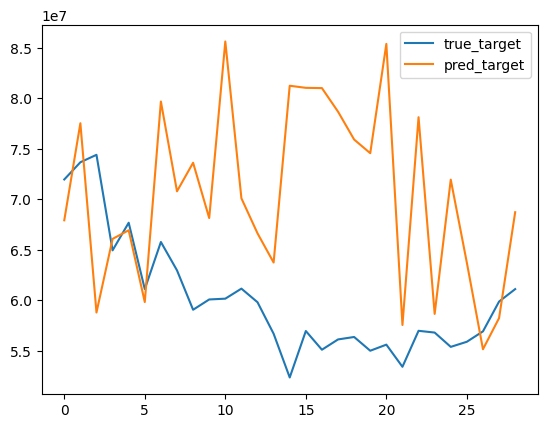

In [236]:
plt.plot(list(range(out_true.shape[0])), out_true['Продажи, рубли'].values, label='true_target')
plt.plot(list(range(out_true.shape[0])), predictions_inv.reshape(predictions_inv.shape[1]), label='pred_target')
plt.legend()
plt.show()

In [237]:
predictions_inv.reshape(predictions_inv.shape[1])

array([67920559.14368863, 77522754.16584337, 58798007.06956995,
       66079953.51529887, 66935205.42297369, 59833720.80109213,
       79670849.5663962 , 70787637.36623655, 73614679.96648845,
       68142620.04509604, 85611870.68611027, 70096704.6068083 ,
       66629901.6962958 , 63742336.62602066, 81232464.9785781 ,
       81025362.9937859 , 80998365.47163787, 78667147.58140446,
       75909717.82678223, 74559375.47468615, 85373306.95601444,
       57561655.96158377, 78119684.17752354, 58658336.07274881,
       71940721.91793485, 63717991.39405263, 55162596.67637248,
       58247292.51630522, 68721249.25453418])

In [238]:
# Предикт таргета для sample submission

inp = data[-n_past:]
out = data[-n_future:][['Продажи, рубли']]
out['Продажи, рубли'] = 0
out.reset_index(drop=True, inplace=True)

In [239]:
inp

,"Продажи, рубли","Продажи, упаковки","Продажи, рубли 1","раствор 0 01 % 150 мл N1, руб","раствор 0 01 % 50 мл N1, руб","раствор 0 01 % 500 мл N1, руб","раствор 0 01 % 150 мл N1, упаковки","раствор 0 01 % 50 мл N1, упаковки","раствор 0 01 % 500 мл N1, упаковки",Дистрибуция Мирамистин,Выписки,Статистика заболеваемости,Индекс цены,Развитие Дженериков средняя дистрибуция,Развитие Дженериков кол-во брендов,"1 ТВ, trp Ж 30-60 ВС","1 ТВ, рубли","1 ТВ, охват 5+ Ж 30-60 ВС","2 ТВ, trp Ж 30-60 ВС","2 ТВ, рубли","2 ТВ, охват 5+ Ж 30-60 ВС","3 ТВ, trp Ж 30-60 ВС","3 ТВ, рубли","3 ТВ, охват 5+ Ж 30-60 ВС","4 ТВ, trp Ж 30-60 ВС","4 ТВ, рубли","4 ТВ, охват 5+ Ж 30-60 ВС","тотал ТВ, trp Ж 30-60 ВС","тотал ТВ, рубли","тотал ТВ, охват 5+ Ж 30-60 ВС","Диджитал, рубли","Радио, рубли","Радио, количество выходов",Запросы Wordstat,"ТВ, trp Ж 30-60 ВС","ТВ, охват 5+ Ж 30-60 ВС","ТВ, рубли","Диджитал, руб","ТВ спонсорство, рубли","OOH, рубли","Радио, рубли 1",Итого,"ТВ, trp Ж 30-60 ВС 1","ТВ, охват 5+ Ж 30-60 ВС 1","ТВ, рубли 1","Диджитал, руб 1","ТВ спонсорство, рубли 1","OOH, рубли 1","Радио, рубли 2",Итого 1,"ТВ, trp Ж 30-60 ВС 2","ТВ, охват 5+ Ж 30-60 ВС 2","ТВ, рубли 2","Диджитал, руб 2","ТВ спонсорство, рубли 2","OOH, рубли 2","Радио, рубли 3","ТВ Рег, рубли",Итого 2,"ТВ, trp Ж 30-60 ВС 3","ТВ, охват 5+ Ж 30-60 ВС 3","ТВ, рубли 3","Диджитал, руб 3","ТВ спонсорство, рубли 3","OOH, рубли 3","Радио, рубли 4",Итого 3,"ТВ, trp Ж 30-60 ВС 4","ТВ, охват 5+ Ж 30-60 ВС 4","ТВ, рубли 4","Диджитал, руб 4","ТВ спонсорство, рубли 4","OOH, рубли 4","Радио, рубли 5","ТВ Рег, рубли 1",Итого 4,"ТВ, trp Ж 30-60 ВС 5","ТВ, охват 5+ Ж 30-60 ВС 5","ТВ, рубли 5","Диджитал, руб 5","ТВ спонсорство, рубли 5","OOH, рубли 5","Радио, рубли 6","ТВ Рег, рубли 2",Итого 5,"ТВ, trp Ж 30-60 ВС 6","ТВ, охват 5+ Ж 30-60 ВС 6","ТВ, рубли 6","Диджитал, руб 6","ТВ спонсорство, рубли 6","OOH, рубли 6","Радио, рубли 7","ТВ Рег, рубли 3",Итого 6,"ТВ, trp Ж 30-60 ВС 7","ТВ, охват 5+ Ж 30-60 ВС 7","ТВ, рубли 7","Диджитал, руб 7","ТВ спонсорство, рубли 7","OOH, рубли 7","Радио, рубли 8",Итого 7,"ТВ, trp Ж 30-60 ВС 8","ТВ, охват 5+ Ж 30-60 ВС 8","ТВ, рубли 8","Диджитал, руб 8","ТВ спонсорство, рубли 8","OOH, рубли 8","Радио, рубли 9","ТВ Рег, рубли 4",Итого 8,"ТВ, trp Ж 30-60 ВС 9","ТВ, охват 5+ Ж 30-60 ВС 9","ТВ, рубли 9","Диджитал, руб 9","ТВ спонсорство, рубли 9","OOH, рубли 9","Радио, рубли 10",Итого 9,"ТВ, trp Ж 30-60 ВС 10","ТВ, охват 5+ Ж 30-60 ВС 10","ТВ, рубли 10","Диджитал, руб 10","ТВ спонсорство, рубли 10","OOH, рубли 10","Радио, рубли 11",Итого 10,"ТВ, trp Ж 30-60 ВС 11","ТВ, охват 5+ Ж 30-60 ВС 11","ТВ, рубли 11","Диджитал, руб 11","ТВ спонсорство, рубли 11","OOH, рубли 11","Радио, рубли 12","ТВ Рег, рубли 5",Итого 11,"ТВ, trp Ж 30-60 ВС 12","ТВ, охват 5+ Ж 30-60 ВС 12","ТВ, рубли 12","Диджитал, руб 12","ТВ спонсорство, рубли 12","OOH, рубли 12","Радио, рубли 13",Итого 12
Начало нед,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-08-07,5.988151e+07,115345.65,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.00,0.0,0.9975,64408.58422,390915.0,1.566483,0.070484,15.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2701755.00,0.000000e+00,0.0,56645.4,26.624656,0.9450,1.894306e+06,0.0,0.0,0.0,0.0,1.894306e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,945.0,0.0,0.0,0.0,0.0,945.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-14,6.111218e+07,117761.70,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.00,0.0,0.9975,64408.58422,398580.0,1.566483,0.070484,15.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4082

In [240]:
out

,"Продажи, рубли"
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [241]:
pd.DataFrame([0]*29, columns=['Продажи, рубли'])

,"Продажи, рубли"
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [242]:
out_true = out[['Продажи, рубли']].copy()
inp = scaler.transform(inp[features])
out = out_true.copy()
out['Продажи, рубли'] = target_scaler.transform(out)

inp_seq, out_seq = np.array([inp]), np.array([out])

inp_seq_tensor = torch.tensor(inp_seq, dtype=torch.float32)
out_seq_tensor = torch.tensor(out_seq, dtype=torch.float32)

inp_out_dataset = TensorDataset(inp_seq_tensor, out_seq_tensor)
inp_out_loader = DataLoader(inp_out_dataset, batch_size=batch_size, shuffle=False)

In [243]:
with open('files/features.pkl', 'wb') as f:
    pickle.dump(features, f)

features

['Продажи, рубли 1',
 'раствор 0 01 % 150 мл N1, руб',
 'раствор  0 01 % 50 мл N1, руб',
 'раствор 0 01 % 500 мл N1, руб',
 'раствор 0 01 % 150 мл N1, упаковки',
 'раствор  0 01 % 50 мл N1, упаковки',
 'раствор 0 01 % 500 мл N1, упаковки',
 'Дистрибуция Мирамистин',
 'Выписки ',
 'Статистика заболеваемости',
 'Индекс цены',
 'Развитие Дженериков   средняя дистрибуция ',
 'Развитие Дженериков   кол-во брендов ',
 ' 1  ТВ, trp  Ж 30-60 ВС ',
 ' 1  ТВ, рубли',
 ' 1  ТВ, охват 5+  Ж 30-60 ВС ',
 ' 2  ТВ, trp  Ж 30-60 ВС ',
 ' 2  ТВ, рубли',
 ' 2  ТВ, охват 5+  Ж 30-60 ВС ',
 ' 3  ТВ, trp  Ж 30-60 ВС ',
 ' 3  ТВ, рубли',
 ' 3  ТВ, охват 5+  Ж 30-60 ВС ',
 ' 4  ТВ, trp  Ж 30-60 ВС ',
 ' 4  ТВ, рубли',
 ' 4  ТВ, охват 5+  Ж 30-60 ВС ',
 ' тотал  ТВ, trp  Ж 30-60 ВС ',
 ' тотал  ТВ, рубли',
 ' тотал  ТВ, охват 5+  Ж 30-60 ВС ',
 'Диджитал, рубли',
 'Радио, рубли',
 'Радио, количество выходов ',
 'Запросы Wordstat',
 'ТВ, trp  Ж 30-60 ВС ',
 'ТВ, охват 5+  Ж 30-60 ВС ',
 'ТВ, рубли',
 'Диджитал

In [244]:
with open('files/features.pkl', 'rb') as f:
    features = pickle.load(f)
features

['Продажи, рубли 1',
 'раствор 0 01 % 150 мл N1, руб',
 'раствор  0 01 % 50 мл N1, руб',
 'раствор 0 01 % 500 мл N1, руб',
 'раствор 0 01 % 150 мл N1, упаковки',
 'раствор  0 01 % 50 мл N1, упаковки',
 'раствор 0 01 % 500 мл N1, упаковки',
 'Дистрибуция Мирамистин',
 'Выписки ',
 'Статистика заболеваемости',
 'Индекс цены',
 'Развитие Дженериков   средняя дистрибуция ',
 'Развитие Дженериков   кол-во брендов ',
 ' 1  ТВ, trp  Ж 30-60 ВС ',
 ' 1  ТВ, рубли',
 ' 1  ТВ, охват 5+  Ж 30-60 ВС ',
 ' 2  ТВ, trp  Ж 30-60 ВС ',
 ' 2  ТВ, рубли',
 ' 2  ТВ, охват 5+  Ж 30-60 ВС ',
 ' 3  ТВ, trp  Ж 30-60 ВС ',
 ' 3  ТВ, рубли',
 ' 3  ТВ, охват 5+  Ж 30-60 ВС ',
 ' 4  ТВ, trp  Ж 30-60 ВС ',
 ' 4  ТВ, рубли',
 ' 4  ТВ, охват 5+  Ж 30-60 ВС ',
 ' тотал  ТВ, trp  Ж 30-60 ВС ',
 ' тотал  ТВ, рубли',
 ' тотал  ТВ, охват 5+  Ж 30-60 ВС ',
 'Диджитал, рубли',
 'Радио, рубли',
 'Радио, количество выходов ',
 'Запросы Wordstat',
 'ТВ, trp  Ж 30-60 ВС ',
 'ТВ, охват 5+  Ж 30-60 ВС ',
 'ТВ, рубли',
 'Диджитал

In [245]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in inp_out_loader:
        outputs = model(inputs)
        predictions.extend(outputs.numpy())
        actuals.extend(targets.view(targets.size(0), -1).numpy())

# Inverse transform the predictions and actuals
predictions_inv = target_scaler.inverse_transform(predictions)

In [246]:
predictions_inv.reshape(predictions_inv.shape[1])

array([67920559.14368863, 77522754.16584337, 58798007.06956995,
       66079953.51529887, 66935205.42297369, 59833720.80109213,
       79670849.5663962 , 70787637.36623655, 73614679.96648845,
       68142620.04509604, 85611870.68611027, 70096704.6068083 ,
       66629901.6962958 , 63742336.62602066, 81232464.9785781 ,
       81025362.9937859 , 80998365.47163787, 78667147.58140446,
       75909717.82678223, 74559375.47468615, 85373306.95601444,
       57561655.96158377, 78119684.17752354, 58658336.07274881,
       71940721.91793485, 63717991.39405263, 55162596.67637248,
       58247292.51630522, 68721249.25453418])

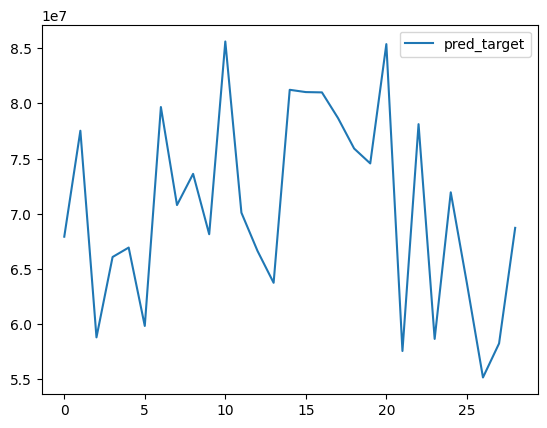

In [247]:
plt.plot(list(range(out_true.shape[0])), predictions_inv.reshape(predictions_inv.shape[1]), label='pred_target')
plt.legend()
plt.show()

In [248]:
subm = pd.read_csv('files/sample_submission.csv')
subm['revenue'] = predictions_inv.reshape(predictions_inv.shape[1])
subm.to_csv('files/submit.csv', index=False)
subm

,week,revenue
0,04.09.2023,6.792056e+07
1,11.09.2023,7.752275e+07
2,18.09.2023,5.879801e+07
3,25.09.2023,6.607995e+07
4,02.10.2023,6.693521e+07
5,09.10.2023,5.983372e+07
6,16.10.2023,7.967085e+07
7,23.10.2023,7.078764e+07
8,30.10.2023,7.361468e+07
9,06.11.2023,6.814262e+07


In [249]:
#### linreg

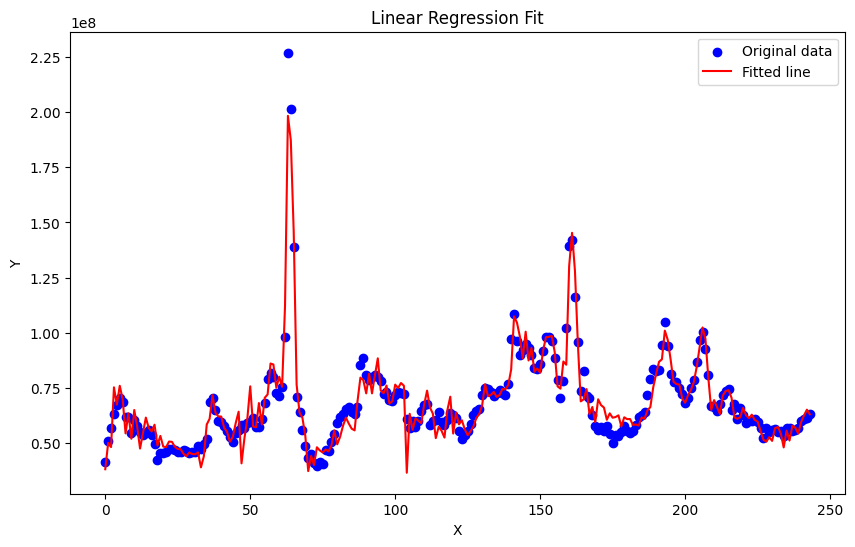

In [250]:
from sklearn.linear_model import LinearRegression

x = data.drop(columns=['Продажи, рубли', 'Продажи, упаковки'])
y = data['Продажи, рубли']
# scaler = StandardScaler()
# x = scaler.fit_transform(x)
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(list(range(len(y))), y, color='blue', label='Original data')
plt.plot(list(range(len(y))), y_pred, color='red', label='Fitted line')
plt.title('Linear Regression Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

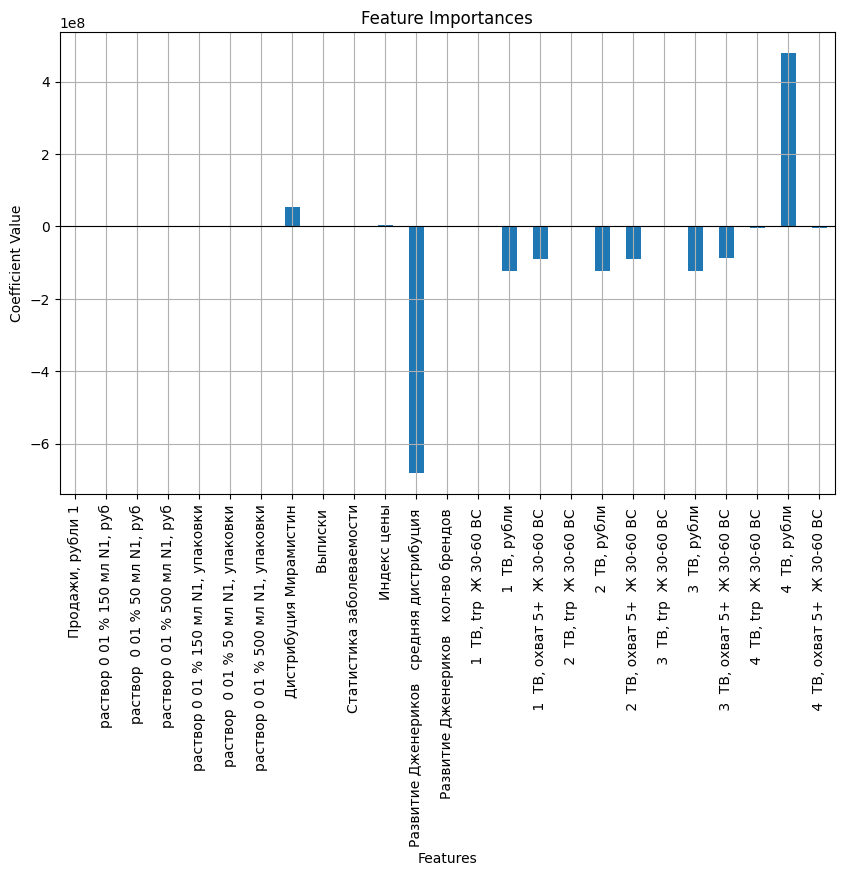

In [251]:
feature_names = x.columns
coefficients = model.coef_

coef_df = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient'])

plt.figure(figsize=(10, 6))
coef_df['Coefficient'][0:25].plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.axhline(y=0, color='black', linewidth=0.8)
plt.show()


In [252]:
coef_df.to_csv('files/coef_df.csv', index=True)